## Practical project 1 - 02 - Beating the baseline

Explainable Automated Machine Learning course, LTAT.02.023
University of Tartu, Institute of Computer Science

Each team will work on a machine learning problem from end-to-end.

#### Project's general description:
<details>
  <summary>Click here for more information!</summary>

  Each team will work on a machine learning problem from end-to-end.

  **Step 1:** Choose a dataset. Build and train a baseline for comparison. To construct the baseline you do the following:
  * Try a set of possible machine learning algorithms (**13 algorithms**) using their **default hyperparameters** and choose the one with the highest performance for comparison.


  **Step 2:** Based on the problem at hand, you study:
  * the **potential pipeline structure**,
  * **algorithms**
  * or **feature transformers** at each step,
  * **hyper-parameters ranges**.
  
  Use hyperOpt with the potential search space to beat the baseline.


  **Step 3:** Monitor the performance of the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.


  **Step 4:** Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

</details>

#### Dataset used:
<details>
  <summary>Click here for more information!</summary>

  Dataset is taken from Kaggle competition - Drinking Water Quality Prediction. The goal of the competition is to create a model that predicts the water quality in Estonian water stations based on the government's open data of the previous measurements.

  [Reference](https://www.kaggle.com/competitions/copy-of-drinking-water-quality)
</details>

</details>

#### References:
<details>
  <summary>Click here for more information!</summary>

  [MLJ for Data Scientists in Two Hours](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/telco/)
</details>

### Activate the current project. Check the packages available

In [1]:
using Pkg

Pkg.activate(".")
Pkg.status()


  Activating project at `/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1`


Status `/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1/Project.toml`
  [336ed68f] CSV v0.10.7
⌃ [a93c6f00] DataFrames v1.3.6
  [add582a8] MLJ v0.18.6
  [c6f25543] MLJDecisionTreeInterface v0.2.5
  [5ae90465] MLJScikitLearnInterface v0.2.0
  [54119dfa] MLJXGBoostInterface v0.2.1
  [91a5bcdd] Plots v1.35.7
Info Packages marked with ⌃ have new versions available and may be upgradable.


### Get packages to use

In [130]:
using DataFrames
using CSV
using MLJ
using Random
using Plots
using Measurements
using Suppressor


using MLJScikitLearnInterface
using MLJDecisionTreeInterface

using MLJParticleSwarmOptimization
using StableRNGs

include("./helper.jl")
using .Helper

### Get adjusted datasets

In [5]:
df_train = CSV.read(joinpath(@__DIR__, "data/adjusted/train_adjusted.csv"), delim=';', DataFrame)
display(first(df_train, 3))
df_test = CSV.read(joinpath(@__DIR__, "data/adjusted/test_adjusted.csv"), delim=';', DataFrame)
display(first(df_test, 3))

,ammonium,coli-like-bacteria,colony-count-at-22-c,color-pt/co-scale,electrical-conductivity
,Float64,Float64,Float64,Float64,Float64
1,0.05,0.0,0.0,0.0,448.0
2,0.09,0.0,15.0,4.0,978.0
3,0.06,0.0,1.0,3.5,446.0


,ammonium,coli-like-bacteria,colony-count-at-22-c,color-pt/co-scale,electrical-conductivity
,Float64,Float64,Float64,Float64,Float64
1,0.08,0.0,12.0,11.7,716.0
2,0.08,0.0,35.3333,7.7,996.0
3,0.065,0.0,58.6667,4.0,734.0


### Adjust the scientific data types

#### View the initiall set scientific data types

In [6]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,ammonium,Continuous,Float64
2,coli-like-bacteria,Continuous,Float64
3,colony-count-at-22-c,Continuous,Float64
4,color-pt/co-scale,Continuous,Float64
5,electrical-conductivity,Continuous,Float64
6,escherichia-coli,Continuous,Float64
7,iron,Continuous,Float64
8,manganese,Continuous,Float64
9,odour-dilution-level,Continuous,Float64


In [7]:
schema(df_test) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,ammonium,Continuous,Float64
2,coli-like-bacteria,Continuous,Float64
3,colony-count-at-22-c,Continuous,Float64
4,color-pt/co-scale,Continuous,Float64
5,electrical-conductivity,Continuous,Float64
6,escherichia-coli,Continuous,Float64
7,iron,Continuous,Float64
8,manganese,Continuous,Float64
9,odour-dilution-level,Continuous,Float64


#### Adjust the scientific data types adn change target column's levels

* change scientific data type for taget column 'compliance': Count -> OrderedFactor
* adjust appropriate levels: negative one (1) should be first

In [8]:
coerce!(df_train, Float64 => Continuous)
# change scientific data type for taget column 'compliance': Count -> OrderedFactor
coerce!(df_train, :compliance => OrderedFactor)
# adjust appropriate levels: negative one (1) should be first
levels!(df_train.compliance, [1, 0])
levels(df_train.compliance)

2-element Vector{Int64}:
 1
 0

In [9]:
coerce!(df_test, Float64 => Continuous)
# change scientific data type for taget column 'compliance': Count -> OrderedFactor
coerce!(df_test, :compliance => OrderedFactor)
# adjust appropriate levels: negative one (1) should be first
levels!(df_test.compliance, [1, 0])
levels(df_test.compliance)

2-element Vector{Int64}:
 1
 0

#### View the adjusted scientific data types

In [10]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,ammonium,Continuous,Float64
2,coli-like-bacteria,Continuous,Float64
3,colony-count-at-22-c,Continuous,Float64
4,color-pt/co-scale,Continuous,Float64
5,electrical-conductivity,Continuous,Float64
6,escherichia-coli,Continuous,Float64
7,iron,Continuous,Float64
8,manganese,Continuous,Float64
9,odour-dilution-level,Continuous,Float64


In [11]:
schema(df_test) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,ammonium,Continuous,Float64
2,coli-like-bacteria,Continuous,Float64
3,colony-count-at-22-c,Continuous,Float64
4,color-pt/co-scale,Continuous,Float64
5,electrical-conductivity,Continuous,Float64
6,escherichia-coli,Continuous,Float64
7,iron,Continuous,Float64
8,manganese,Continuous,Float64
9,odour-dilution-level,Continuous,Float64


### Split the data "horizontally" into input and target parts

In [12]:
y, X = unpack(df_train, ==(:compliance), col -> true)
first(X, 3) |> pretty

┌────────────┬────────────────────┬──────────────────────┬───────────────────┬─────────────────────────┬──────────────────┬────────────┬────────────┬──────────────────────┬───────────────────────┬───────────────┬────────────┐
│ ammonium   │ coli-like-bacteria │ colony-count-at-22-c │ color-pt/co-scale │ electrical-conductivity │ escherichia-coli │ iron       │ manganese  │ odour-dilution-level │ taste-dilution-degree │ turbidity-ntu │ ph         │
│ Float64    │ Float64            │ Float64              │ Float64           │ Float64                 │ Float64          │ Float64    │ Float64    │ Float64              │ Float64               │ Float64       │ Float64    │
│ Continuous │ Continuous         │ Continuous           │ Continuous        │ Continuous              │ Continuous       │ Continuous │ Continuous │ Continuous           │ Continuous            │ Continuous    │ Continuous │
├────────────┼────────────────────┼──────────────────────┼───────────────────┼──────────────────

In [13]:
y_test, X_test = unpack(df_test, ==(:compliance), col -> true)
first(X_test, 3) |> pretty

┌────────────┬────────────────────┬──────────────────────┬───────────────────┬─────────────────────────┬──────────────────┬────────────┬────────────┬──────────────────────┬───────────────────────┬───────────────┬────────────┐
│ ammonium   │ coli-like-bacteria │ colony-count-at-22-c │ color-pt/co-scale │ electrical-conductivity │ escherichia-coli │ iron       │ manganese  │ odour-dilution-level │ taste-dilution-degree │ turbidity-ntu │ ph         │
│ Float64    │ Float64            │ Float64              │ Float64           │ Float64                 │ Float64          │ Float64    │ Float64    │ Float64              │ Float64               │ Float64       │ Float64    │
│ Continuous │ Continuous         │ Continuous           │ Continuous        │ Continuous              │ Continuous       │ Continuous │ Continuous │ Continuous           │ Continuous            │ Continuous    │ Continuous │
├────────────┼────────────────────┼──────────────────────┼───────────────────┼──────────────────

### Baseline

#### Dataset partition on train/validation

In [14]:
X_train, X_validation = partition(1:length(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  534, 535, 536, 537, 538, 539, 540, 541, 542, 543], [544, 545, 546, 547, 548, 549, 550, 551, 552, 553  …  767, 768, 769, 770, 771, 772, 773, 774, 775, 776])

#### Define model

In [15]:
RandomForestClassifier = @load RandomForestClassifier pkg=ScikitLearn
model_rfc = RandomForestClassifier()

import MLJScikitLearnInterface ✔


RandomForestClassifier(
  n_estimators = 100, 
  criterion = "gini", 
  max_depth = nothing, 
  min_samples_split = 2, 
  min_samples_leaf = 1, 
  min_weight_fraction_leaf = 0.0, 
  max_features = "auto", 
  max_leaf_nodes = nothing, 
  min_impurity_decrease = 0.0, 
  bootstrap = true, 
  oob_score = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0, 
  warm_start = false, 
  class_weight = nothing, 
  ccp_alpha = 0.0, 
  max_samples = nothing)

#### Fit base model

In [69]:
machine_base = machine(model_rfc, X, y)

@suppress begin
fit!(machine_base, rows=X_train)
end

trained Machine; caches model-specific representations of data
  model: RandomForestClassifier(n_estimators = 100, …)
  args: 
    1:	Source @113 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @009 ⏎ AbstractVector{OrderedFactor{2}}


In [70]:
ŷ_base = predict(machine_base, rows=X_validation)

print(
    "Base model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_base, y[X_validation]) |> mean, "\n",
    "  auc:          ", auc(ŷ_base, y[X_validation]),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_base), y[X_validation])
)

Base model measurements on test: 
  brier loss:   0.15663862660944206
  auc:          0.9185073238781679
  accuracy:     0.9098712446351931

#### Feature importance table

In [17]:
# get fitted parameters
fp = fitted_params(machine_base)
keys(fp)
# get feature_importances as a DataFrame
fi = fp.feature_importances
fi_df = (feature=Symbol.(names(X)), importance=fi) |> DataFrames.DataFrame
sort!(fi_df, [:importance], rev=true)

/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
,Symbol,Float64
1,iron,0.254628
2,manganese,0.210179
3,turbidity-ntu,0.0970157
4,electrical-conductivity,0.0769301
5,colony-count-at-22-c,0.0662138
6,ammonium,0.0632528
7,ph,0.0571182
8,coli-like-bacteria,0.0552913
9,color-pt/co-scale,0.0452828


### HPO related activities

#### Pipeline creation

In [58]:
# Filtering less important features
lessimportant_features = filter(:importance => <(0.02), fi_df).feature
# Pipeline creation
pipe = FeatureSelector(features=lessimportant_features, ignore=true) |> model_rfc

ProbabilisticPipeline(
  feature_selector = FeatureSelector(
        features = [Symbol("escherichia-coli")], 
        ignore = true), 
  random_forest_classifier = RandomForestClassifier(
        n_estimators = 100, 
        criterion = "gini", 
        max_depth = nothing, 
        min_samples_split = 2, 
        min_samples_leaf = 1, 
        min_weight_fraction_leaf = 0.0, 
        max_features = "auto", 
        max_leaf_nodes = nothing, 
        min_impurity_decrease = 0.0, 
        bootstrap = true, 
        oob_score = false, 
        n_jobs = nothing, 
        random_state = nothing, 
        verbose = 0, 
        warm_start = false, 
        class_weight = nothing, 
        ccp_alpha = 0.0, 
        max_samples = nothing), 
  cache = true)

#### Display the model to a larger depth

In [59]:
show(pipe, 2)

ProbabilisticPipeline(
  feature_selector = FeatureSelector(
        features = [Symbol("escherichia-coli")], 
        ignore = true), 
  random_forest_classifier = RandomForestClassifier(
        n_estimators = 100, 
        criterion = "gini", 
        max_depth = nothing, 
        min_samples_split = 2, 
        min_samples_leaf = 1, 
        min_weight_fraction_leaf = 0.0, 
        max_features = "auto", 
        max_leaf_nodes = nothing, 
        min_impurity_decrease = 0.0, 
        bootstrap = true, 
        oob_score = false, 
        n_jobs = nothing, 
        random_state = nothing, 
        verbose = 0, 
        warm_start = false, 
        class_weight = nothing, 
        ccp_alpha = 0.0, 
        max_samples = nothing), 
  cache = true)

#### Define hyperparameters to tune and ranges

In [162]:
p1 = :(random_forest_classifier.max_depth)
p2 = :(random_forest_classifier.n_estimators)
p3 = :(random_forest_classifier.max_features)
p4 = :(random_forest_classifier.min_samples_leaf)
p5 = :(random_forest_classifier.bootstrap)
p6 = :(random_forest_classifier.min_samples_split)

r1 = range(pipe, p1, lower=2, upper=10)
r2 = range(pipe, p2, lower=100, upper=200)
r3 = range(pipe, p3, values=["sqrt", "log2"])
r4 = range(pipe, p4, values=[3, 4, 5, 6])
r5 = range(pipe, p5, values=[true, false])
r6 = range(pipe, p6, values=[2, 3, 4, 5, 6])

NominalRange(random_forest_classifier.min_samples_split = 2, 3, 4, ...)

### Tuning using 'Random search' technique

In [163]:
tuning_random = RandomSearch(rng=123)
pipe_tuned_random = TunedModel(model=pipe,
                        range=[r1, r2, r3, r4, r5, r6],
                        tuning=tuning_random,
                        measures=[brier_loss, auc, accuracy],
                        resampling=StratifiedCV(nfolds=6, rng=123),
                        acceleration=CPUThreads(),
                        n=50) # n specifies the total number of models (set of hyperparameters) to evaluate

machine_pipe_tuned_random = machine(pipe_tuned_random, X, y)

@suppress begin
fit!(machine_pipe_tuned_random, verbosity=0)
end

trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = ProbabilisticPipeline(feature_selector = FeatureSelector(features = [Symbol("escherichia-coli")], …), …), …)
  args: 
    1:	Source @778 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @467 ⏎ AbstractVector{OrderedFactor{2}}


#### Get the best model

In [164]:
report_machine_pipe_tuned_random = report(machine_pipe_tuned_random)
best_model_machine_pipe_tuned_random = report_machine_pipe_tuned_random.best_model.random_forest_classifier

# Optimal hyper-parameters
println(
    "Optimal hyper-parameters: \n",
    "  max_depth:   ", best_model_machine_pipe_tuned_random.max_depth, "\n",
    "  n_estimator: ", best_model_machine_pipe_tuned_random.n_estimators, "\n",
    "  max_features: ", best_model_machine_pipe_tuned_random.max_features, "\n",
    "  min_samples_leaf: ", best_model_machine_pipe_tuned_random.min_samples_leaf, "\n",
    "  bootstrap: ", best_model_machine_pipe_tuned_random.bootstrap, "\n",
    "  min_samples_split: ", best_model_machine_pipe_tuned_random.min_samples_split, "\n"
)
# Confidence intervals
best_history_entry = report_machine_pipe_tuned_random.best_history_entry
Helper.confidence_intervals(best_history_entry)

Optimal hyper-parameters: 
  max_depth:   9
  n_estimator: 107
  max_features: sqrt
  min_samples_leaf: 4
  bootstrap: false
  min_samples_split: 4



,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.148±0.02
2,AreaUnderCurve(),0.928±0.019
3,Accuracy(),0.907±0.021


#### Visualize the optimization results

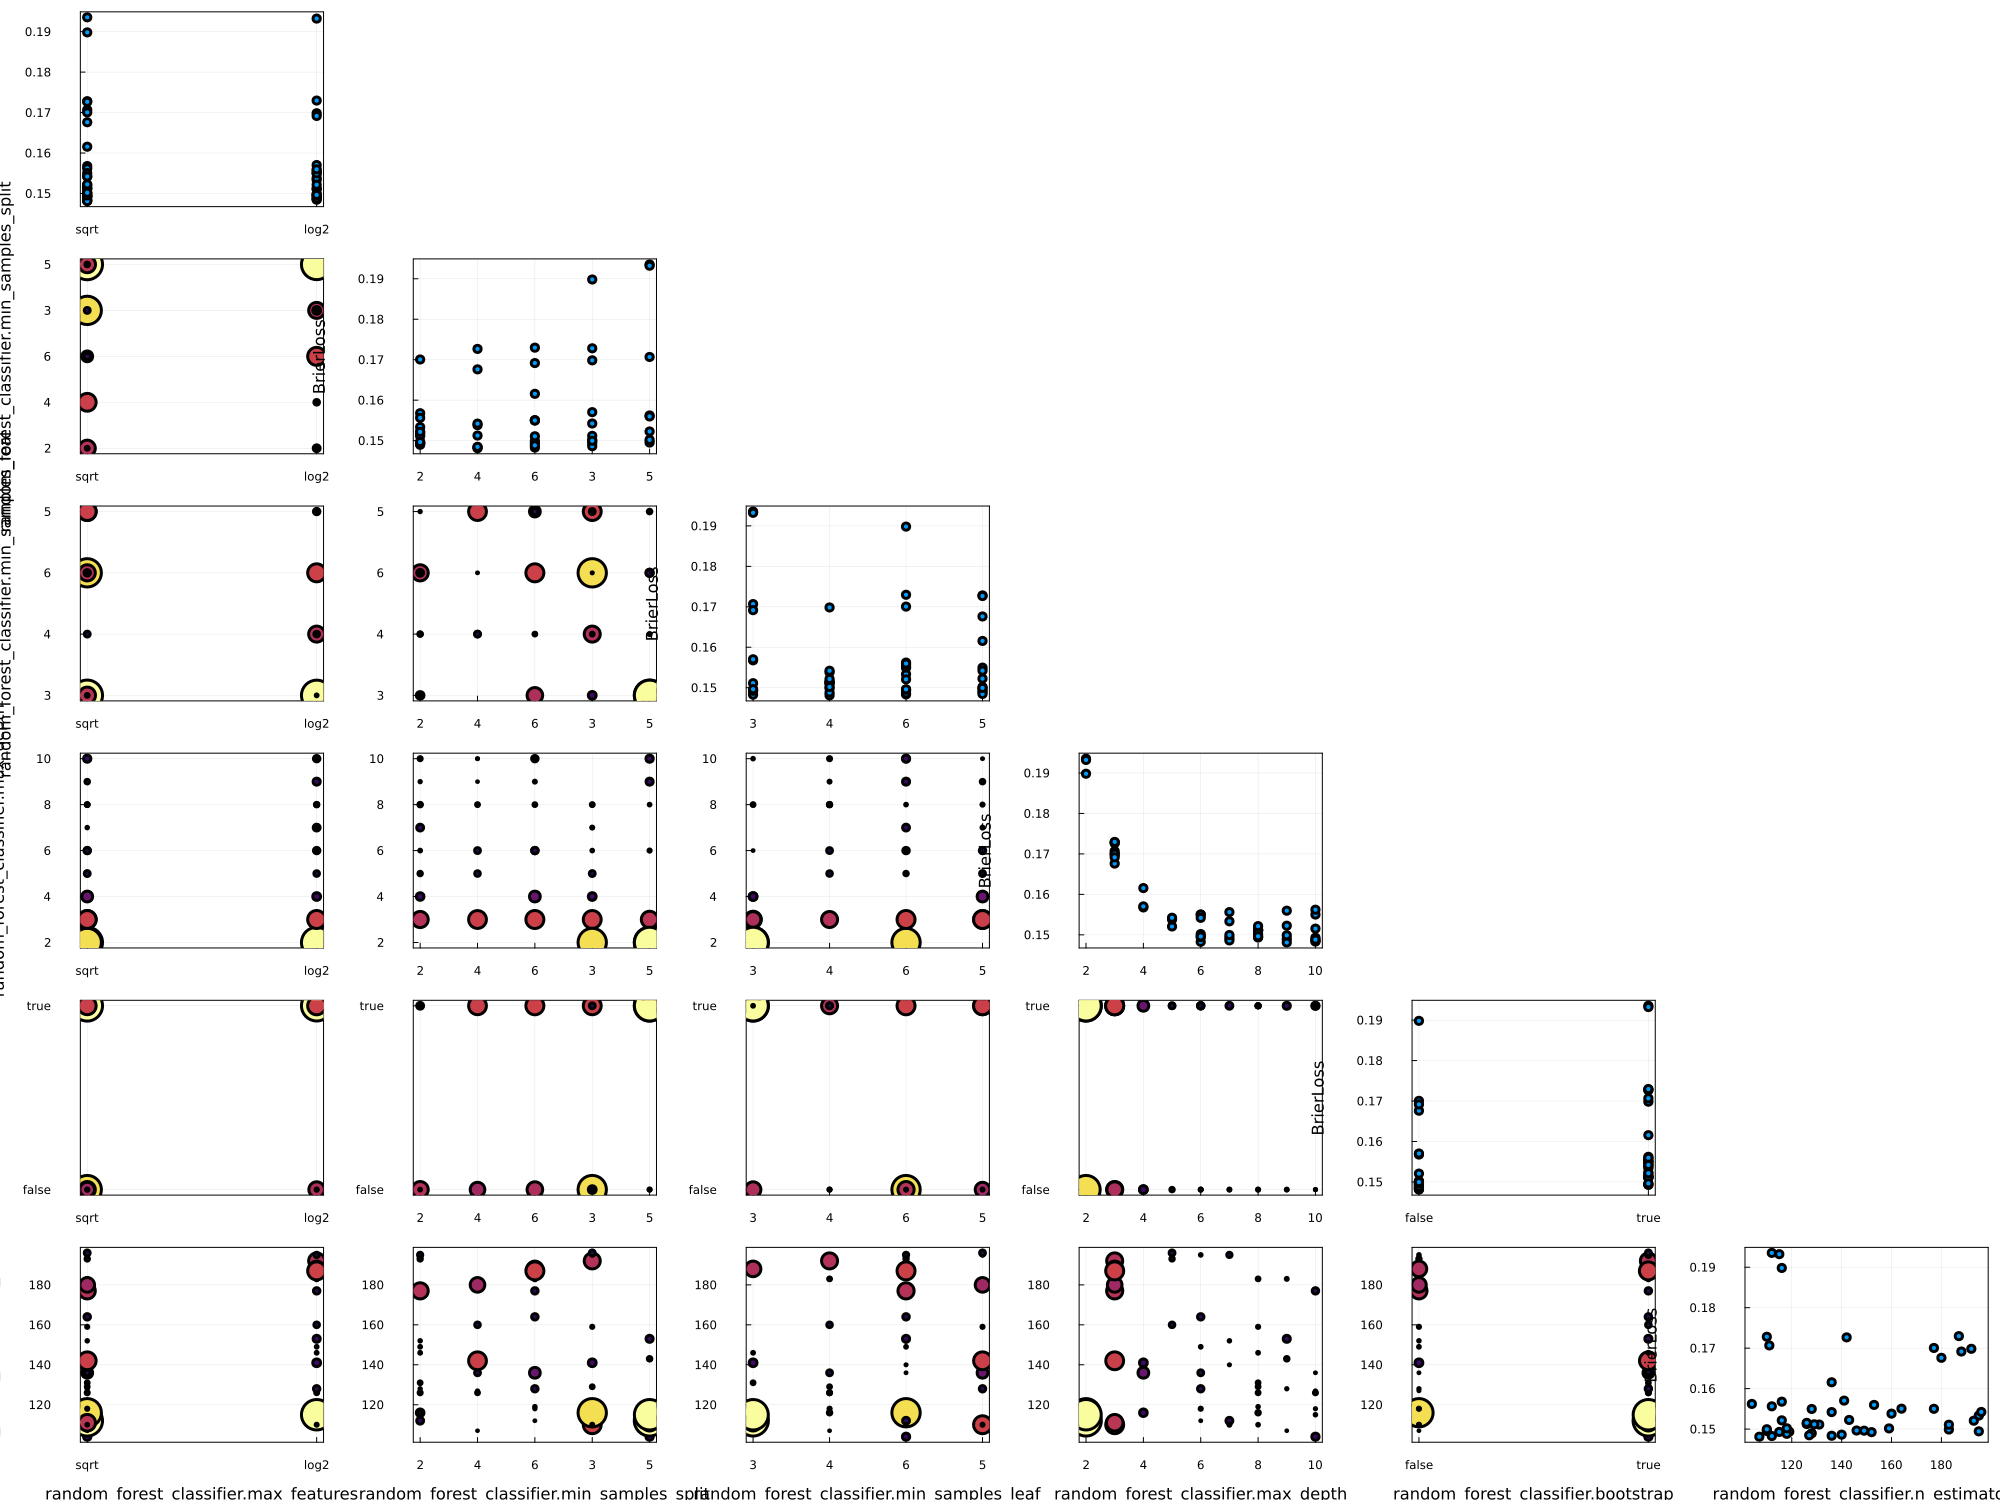

In [165]:
plot(machine_pipe_tuned_random, size=(2000, 1500))

### Tuning using 'AdaptiveParticleSwarm' technique

In [166]:
tuning_aps = AdaptiveParticleSwarm(rng=StableRNG(0))
pipe_tuned_aps = TunedModel(model=pipe,
                        range=[r1, r2, r3, r4, r5, r6],
                        tuning=tuning_aps,
                        measures=[brier_loss, auc, accuracy],
                        resampling=CV(nfolds=6, rng=StableRNG(1)),
                        acceleration=CPUThreads(),
                        n=50) # n specifies the total number of models (set of hyperparameters) to evaluate

machine_pipe_tuned_aps = machine(pipe_tuned_aps, X, y)

@suppress begin
fit!(machine_pipe_tuned_aps, verbosity=0)
end

trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = ProbabilisticPipeline(feature_selector = FeatureSelector(features = [Symbol("escherichia-coli")], …), …), …)
  args: 
    1:	Source @363 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @467 ⏎ AbstractVector{OrderedFactor{2}}


#### Get the best model

In [167]:
report_machine_pipe_tuned_aps = report(machine_pipe_tuned_aps)
best_model_machine_pipe_tuned_aps = report_machine_pipe_tuned_aps.best_model.random_forest_classifier

# Optimal hyper-parameters
println(
    "Optimal hyper-parameters: \n",
    "  max_depth:   ", best_model_machine_pipe_tuned_aps.max_depth, "\n",
    "  n_estimator: ", best_model_machine_pipe_tuned_aps.n_estimators, "\n",
    "  max_features: ", best_model_machine_pipe_tuned_aps.max_features, "\n",
    "  min_samples_leaf: ", best_model_machine_pipe_tuned_aps.min_samples_leaf, "\n",
    "  bootstrap: ", best_model_machine_pipe_tuned_aps.bootstrap, "\n",
    "  min_samples_split: ", best_model_machine_pipe_tuned_aps.min_samples_split, "\n"
)
# Confidence intervals
best_history_entry_aps = report_machine_pipe_tuned_aps.best_history_entry
Helper.confidence_intervals(best_history_entry_aps)

Optimal hyper-parameters: 
  max_depth:   10
  n_estimator: 123
  max_features: sqrt
  min_samples_leaf: 3
  bootstrap: false
  min_samples_split: 4



,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.141±0.037
2,AreaUnderCurve(),0.932±0.033
3,Accuracy(),0.911±0.028


#### Visualize the optimization result

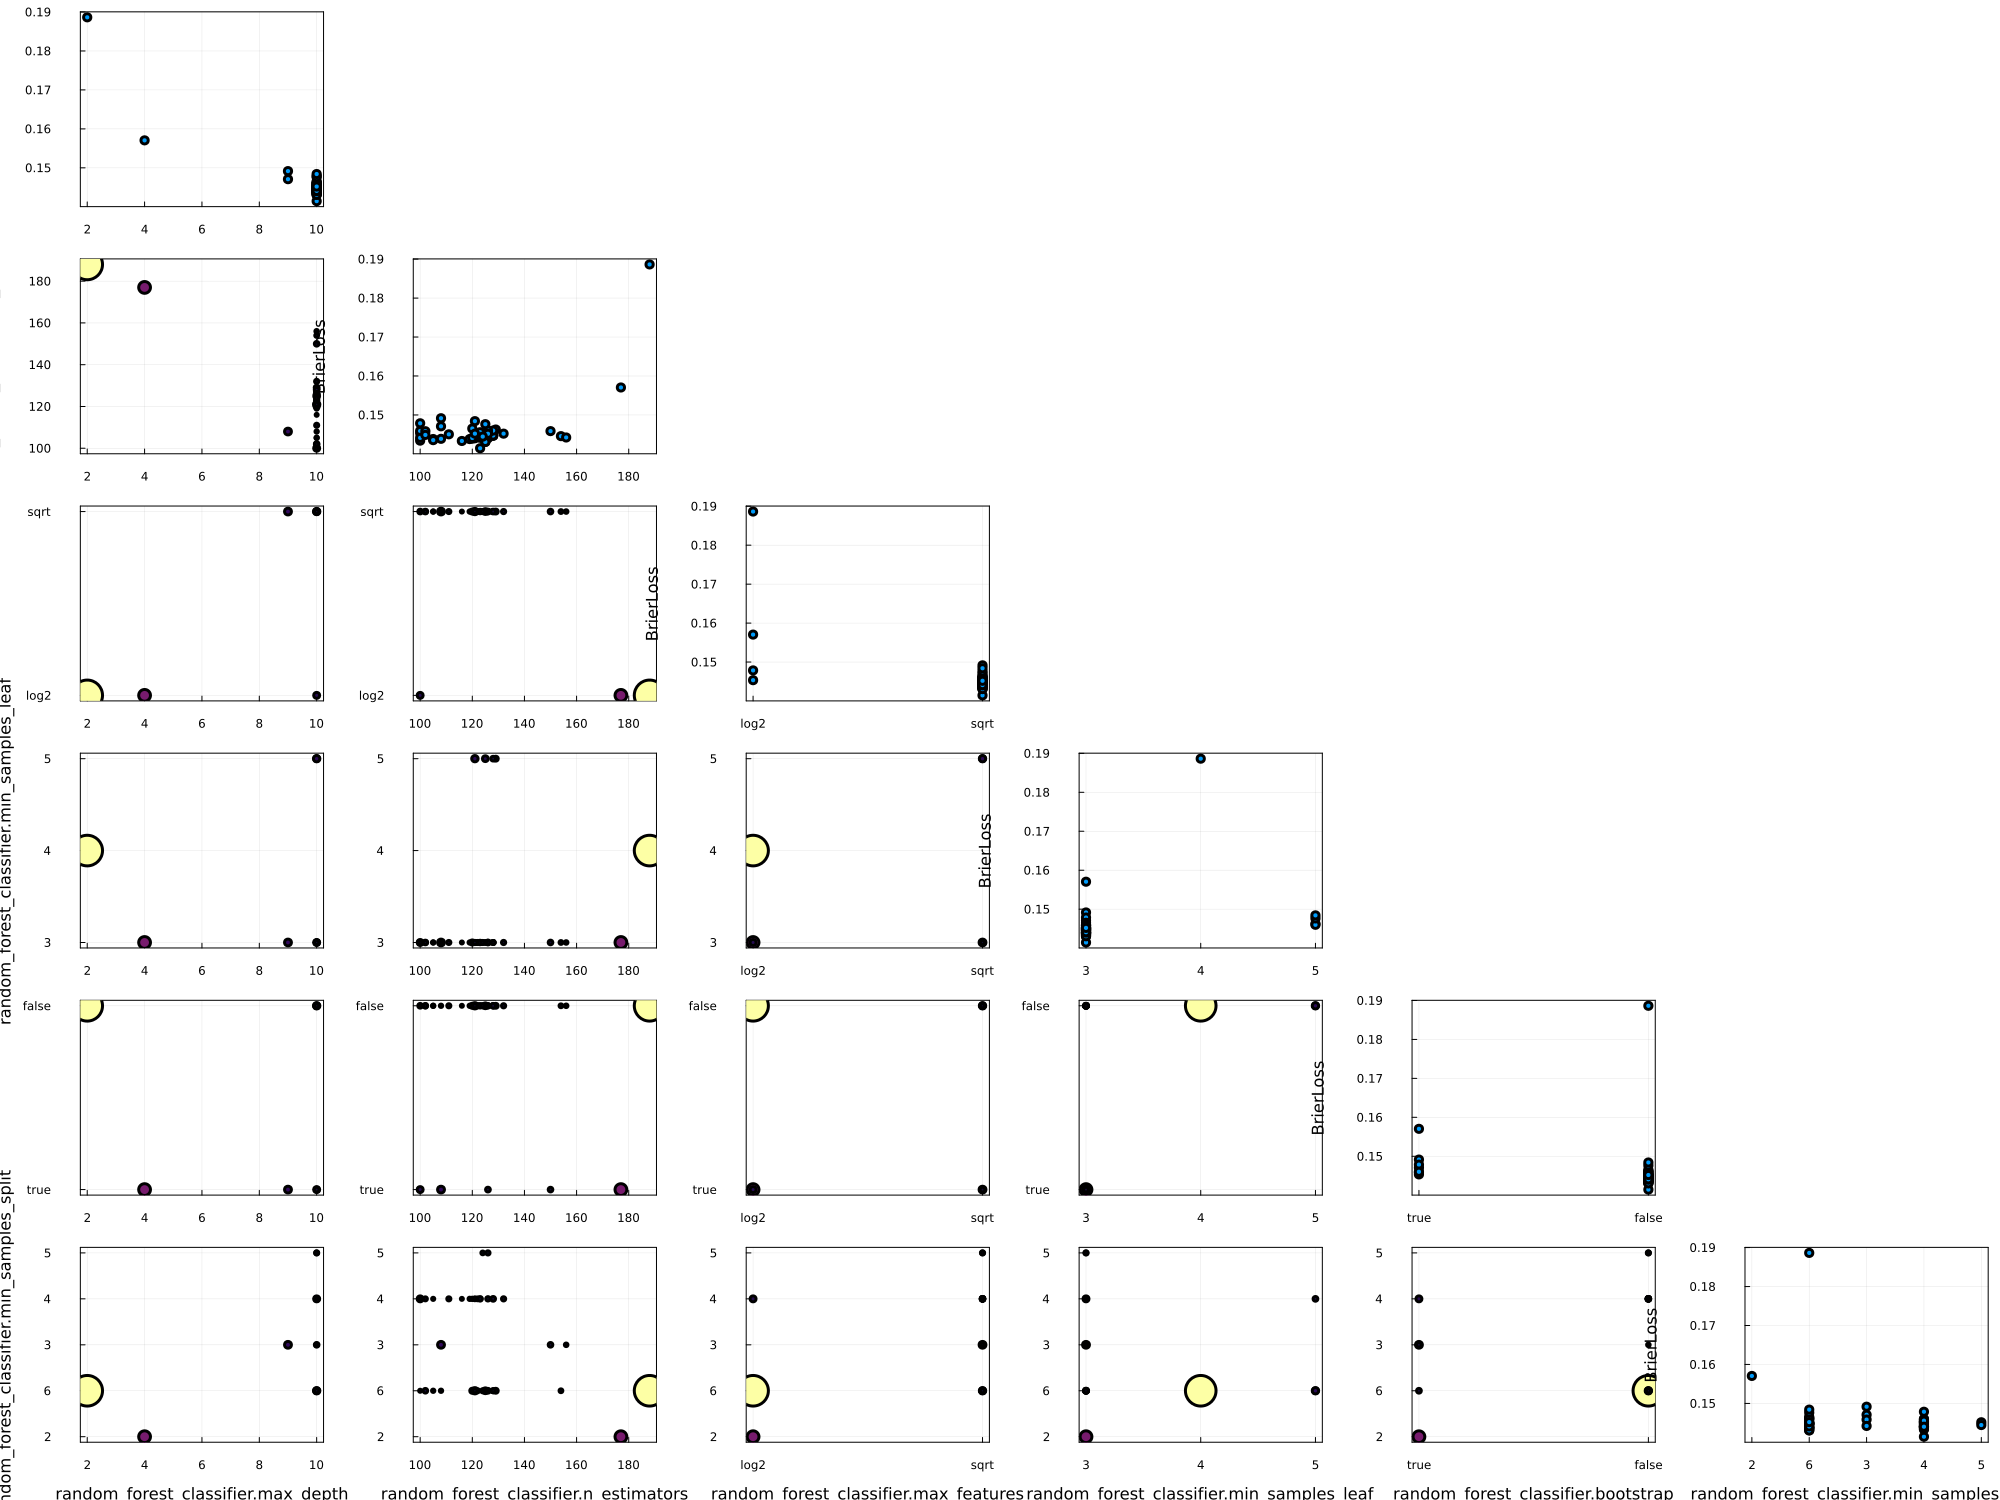

In [168]:
plot(machine_pipe_tuned_aps, size=(2000, 1500))

### Testing the final model

#### Performance for 'Random search' technique

In [169]:
ŷ_tuned_random = predict(machine_pipe_tuned_random, X_test)
ŷ_tuned_random[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■ 0.13314749510194523                   
   0 ┤■■■■■■■■■■■■■■■■■■■■ 0.8668525048980548   
     └                                        ┘ 

In [170]:
print(
    "Tuned model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_tuned_random, y_test) |> mean, "\n",
    "  auc:         ", auc(ŷ_tuned_random, y_test),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_tuned_random), y_test)
)

Tuned model measurements on test: 
  brier loss:   0.15585094025261653
  auc:         0.9197427480404636
  accuracy:     0.8974358974358975

#### Performance for 'AdaptiveParticleSwarm' technique

In [171]:
ŷ_tuned_aps = predict(machine_pipe_tuned_aps, X_test)
ŷ_tuned_aps[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■ 0.12841274697480434                   
   0 ┤■■■■■■■■■■■■■■■■■■■■ 0.8715872530251951   
     └                                        ┘ 

In [172]:
print(
    "Tuned model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_tuned_aps, y_test) |> mean, "\n",
    "  auc:         ", auc(ŷ_tuned_aps, y_test),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_tuned_aps), y_test)
)

Tuned model measurements on test: 
  brier loss:   0.15633917208401532
  auc:         0.9240302806994037
  accuracy:     0.9006410256410257

#### Performance for the 'Base' model

In [173]:
ŷ_base = predict(machine_base, X_test)
ŷ_base[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■■■■■ 0.17                              
   0 ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.83   
     └                                        ┘ 

In [174]:
print(
    "Tuned model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_base, y_test) |> mean, "\n",
    "  auc:          ", auc(ŷ_base, y_test),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_base), y_test)
)

Tuned model measurements on test: 
  brier loss:   0.16805833333333334
  auc:          0.9071481208548269
  accuracy:     0.8878205128205128